# 이상 매출 탐지

- 매출의 급증, 급감을 미리 인지하고 고용인원 수를 조정하고자 하는 문제를 풀고자 한다.
- 분석 과정은 다음과 같다.
    1. 데이터 변환 및 범주확인
    2. EDA
        - 단변량 확인
        - 변량 간 관계 확인
    3. 가설검증
    4. 이상 감지

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random
sys.path.append(os.path.dirname(os.getcwd()))
import rrcf

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 변환 및 범주 확인

- 시간, 숫자 등 데이터 타입을 변환하고 온도 변수의 스케일을 조정한다.
- 매출(이상 탐지 대상)의 일주일 전 값(1 step lag)을 파생변수로 추가한다.
    - 일주일 전 매출과 현재 매출 간 관계를 탐색하는 과정은 생략했으나, stream 데이터의 경우 대체로 직전 추세가 현재로 이어질 가능성이 크다. 그래서 stream 이상탐지에 종종 lag 값이 사용된다.

In [2]:
data = pd.read_csv('./data01_이상매출.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")
# 화씨온도 > 섭씨온도 변환 
data['Temperature']= (data['Temperature']-32) / 1.8

data['Weekly_lag'] = data['Weekly_Sales'].shift(1)
data['Weekly_lag'] = data['Weekly_lag'].fillna(data['Weekly_Sales'])

In [3]:
data.head(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_lag
0,1,2010-02-05,1643690.90,0,5.727778,2.572,211.096358,8.106,1643690.90
1,1,2010-02-12,1641957.44,1,3.616667,2.548,211.242170,8.106,1643690.90
2,1,2010-02-19,1611968.17,0,4.405556,2.514,211.289143,8.106,1641957.44


In [4]:
data.tail(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_lag
6432,45,2012-10-12,734464.36,0,12.483333,4.000,192.327265,8.667,733455.07
6433,45,2012-10-19,718125.53,0,13.594444,3.969,192.330854,8.667,734464.36
6434,45,2012-10-26,760281.43,0,14.916667,3.882,192.308899,8.667,718125.53


In [5]:
X_cols = data.columns[4:]
y_col = data.columns[2]

## 2. EDA
### 단변량 확인

- 지점별 매출의 스케일이 다르며, 시기에 따라 몇몇 매출 급등이 보인다.
- 지점 별 매출 흐름의 유사성을 파악해 매출 특성 별 지점을 군집화한 후 이상감지를 할 수 있다. 이는 비지니스의 상황과 문제정의에 따라 다르다.

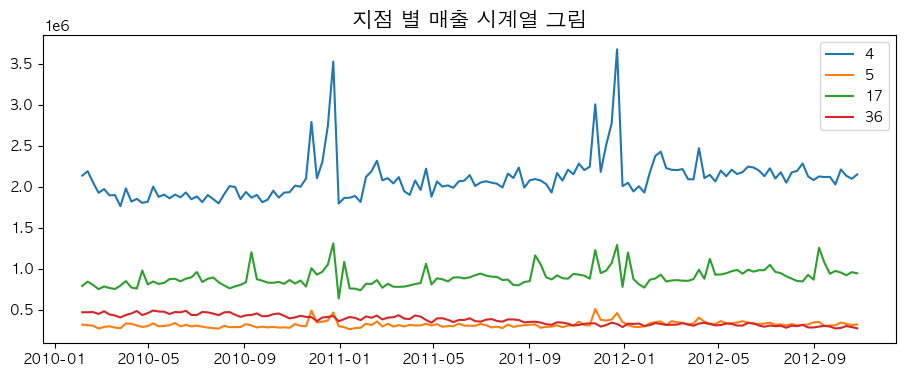

In [6]:
grp_list = data.groupby('Store')
keys = list(grp_list.groups.keys())
store_list = np.sort(random.sample(keys,4))
plt.figure(figsize=(11,4))
for store_ in store_list:
    grp = grp_list.get_group(store_).copy()
    plt.plot(grp['Date'],grp[y_col], label=store_)
plt.legend()
plt.title("지점 별 매출 시계열 그림", size=15)
plt.show()

- 매출의 원 스케일로 보면 지점 간 변동의 흐름 파악이 어려울 수 있다. <br/>
$\rightarrow$ 스케일을 표준화한 후 지점 별 매출 흐름을 파악하면 변동 파악이 쉽다.

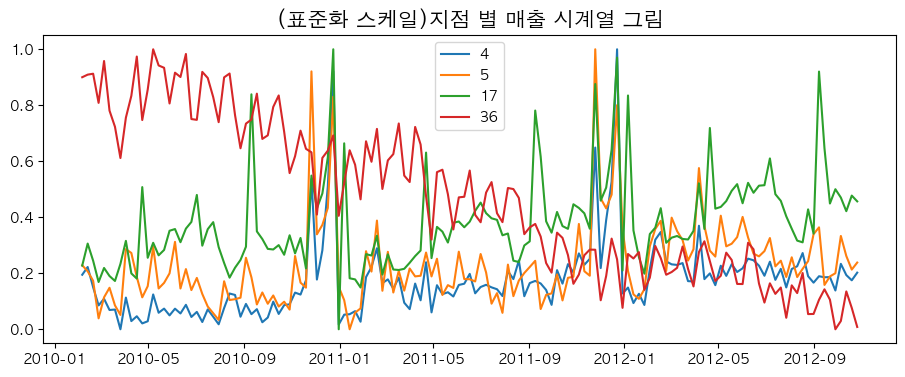

In [7]:
plt.figure(figsize=(11,4))
for store_ in store_list:
    grp = grp_list.get_group(store_).reset_index(drop=True).copy()
    grp[y_col] = (grp[y_col] - grp[y_col].min())/(grp[y_col].max()-grp[y_col].min())
    plt.plot(grp['Date'],grp[y_col], label=store_)
plt.legend()
plt.title("(표준화 스케일)지점 별 매출 시계열 그림", size=15)
plt.show()

- 지점별, 공휴일 여부 별 평균 매출은 다음과 같다. 거의 모든 지점에서 공휴일(Holiday_Flag=1)의 매출이 높다.

In [8]:
np.round(data.groupby(['Store','Holiday_Flag'])[y_col].mean().reset_index().pivot_table(index="Store",columns="Holiday_Flag", values="Weekly_Sales").head(5),1)

Holiday_Flag,0,1
Store,,
1,1546957.4,1665747.7
2,1914208.8,2079266.9
3,400064.8,437811.0
4,2083555.8,2243102.6
5,314892.3,359501.6


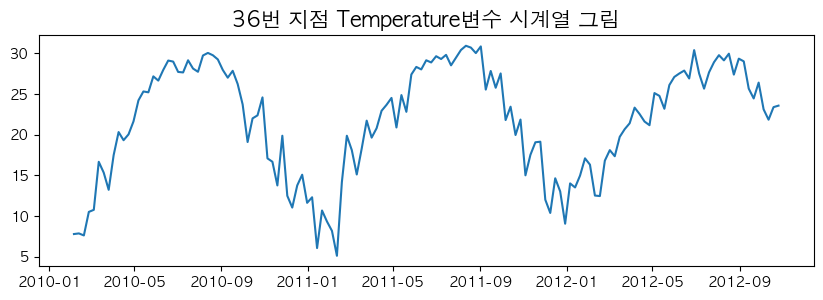

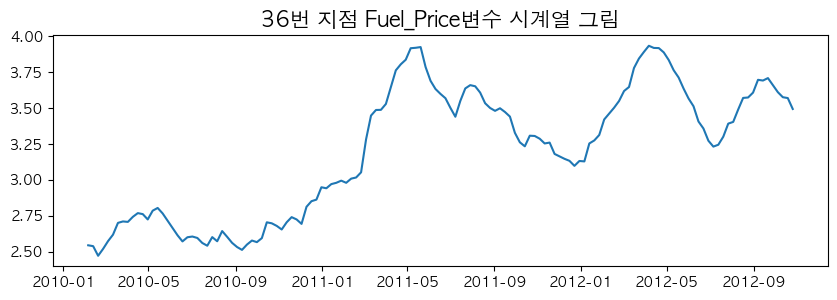

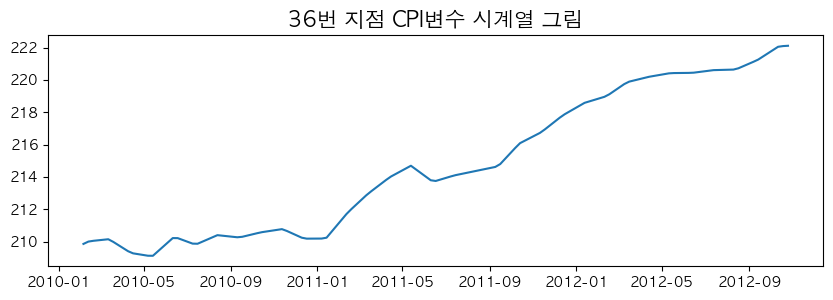

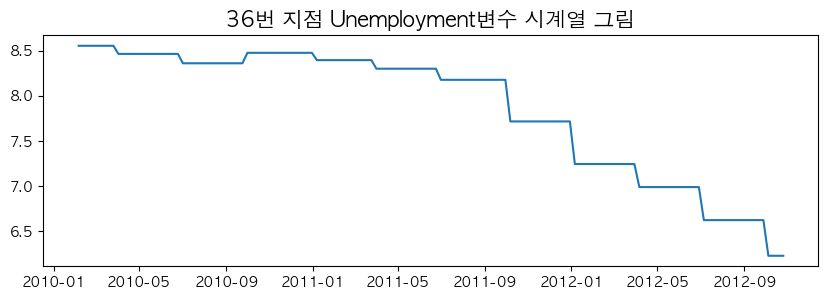

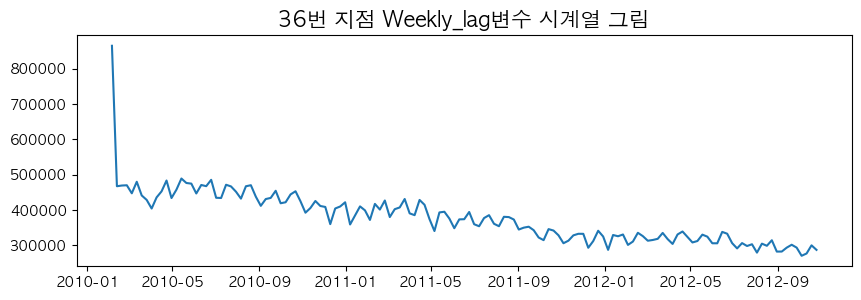

In [9]:
for col in X_cols:
    plt.figure(figsize=(10,3))
    plt.plot(grp['Date'],grp[col])
    plt.title(f"{store_}번 지점 {col}변수 시계열 그림", size=15)
    plt.show()

## 변량 간 관계 확인

- (X-y)매출과 온도, 실업률 등의 변수와의 관계를 확인한다.
    - 같은 변수라 하더라도 지점 별 양상이 전혀 다를 수 있다.
- (X) 매출을 제외한 변수 간 관계를 확인한다.

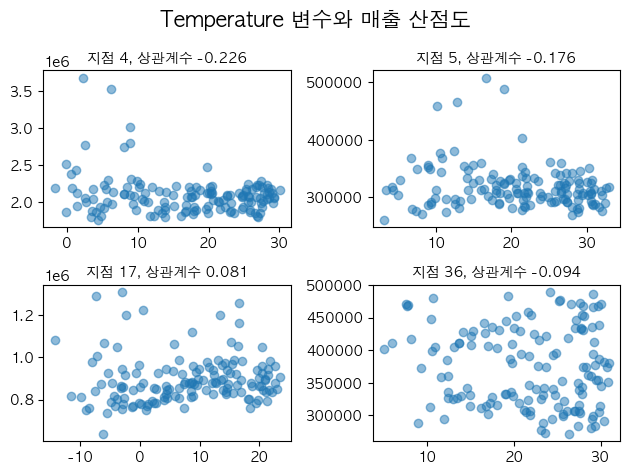

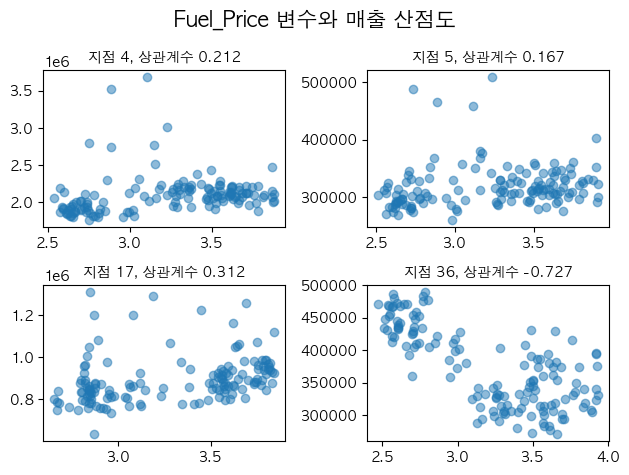

In [10]:
for col in X_cols[:2]:
    for idx,store_ in enumerate(store_list):
        plt.subplot(2,2,idx+1)
        grp = grp_list.get_group(store_)   
        corr_ = np.round(grp[[col,y_col]].corr().iloc[0,1],3) 
        plt.scatter(grp[col],grp[y_col], alpha=0.5)
        plt.title(f"지점 {store_}, 상관계수 {corr_}", size=10)
    plt.suptitle(f"{col} 변수와 매출 산점도", size=15)
    plt.tight_layout()
    plt.show()

In [11]:
store_ = store_list[0]
print(f"{store_}번 지점의 변수 간 상관계수")
grp = grp_list.get_group(store_)   
np.round(grp[X_cols].corr(),3)

4번 지점의 변수 간 상관계수


,Temperature,Fuel_Price,CPI,Unemployment,Weekly_lag
Temperature,1.000,0.287,0.164,-0.221,-0.180
Fuel_Price,0.287,1.000,0.860,-0.799,0.244
CPI,0.164,0.860,1.000,-0.964,0.361
Unemployment,-0.221,-0.799,-0.964,1.000,-0.355
Weekly_lag,-0.180,0.244,0.361,-0.355,1.000


## 이상탐지
- stream 데이터에서의 이상탐지를 위해 RRCF 알고리즘을 사용한다.

- 주의! RRCF에서는 numpy 버전이 너무 높을 경우 np.int, np.bool, np.asscalar 오류가 남
- 높은 numpy 버전을 사용한다면, 동일 폴더 내 rrcf.py를 사용하길 바란다.

In [12]:
# ▶ (1) Batch Detection

df_rrcf = data.loc[data['Store']==1,list(X_cols)+['Weekly_lag']].copy().reset_index(drop=True)

# ▶ Set parameters
np.random.seed(0)
n = len(df_rrcf)
num_trees = 100
tree_size = 32

# 데이터 row 하나하나를 array화한다.
X= df_rrcf.values


# ▶ Construct forest
forest = []
while len(forest) < num_trees:
    # ▶ Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
    # ▶ Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

# ▶ Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [13]:
df1 = data.loc[data['Store']==1].reset_index(drop=True)

In [14]:
def min_max(x):
    return (x-min(x))/(max(x)-min(x))

- 매출 급등 직전에 이상을 감지할 수 있다.

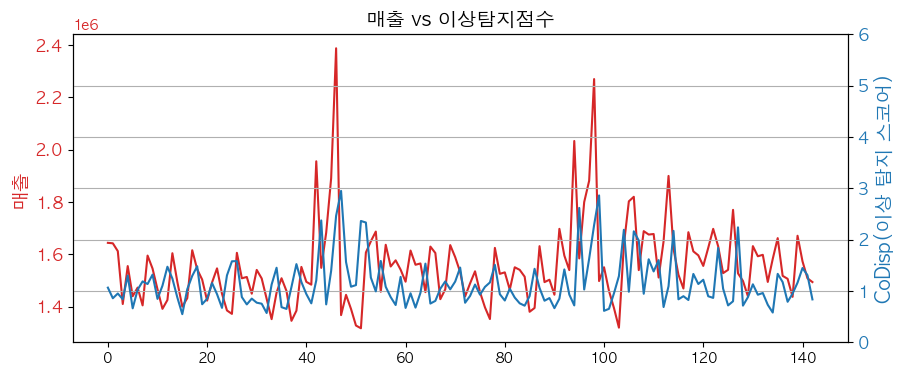

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 4))

color = 'tab:red'
ax1.set_ylabel('매출', color=color, size=14)
ax1.plot(df1['Weekly_Sales'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
#ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp(이상 탐지 스코어)', color=color, size=14)
ax2.plot(pd.Series(np.log(avg_codisp)).sort_index(), color=color)
# ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 6)
plt.title('매출 vs 이상탐지점수', size=14)
plt.show()

In [16]:
avg_codisp.index = df1.index
df1['avg_codisp'] = avg_codisp
# ▶ Threshold 조정
df1['anomaly'] = np.where(df1['avg_codisp']>4.5, 1, 0)

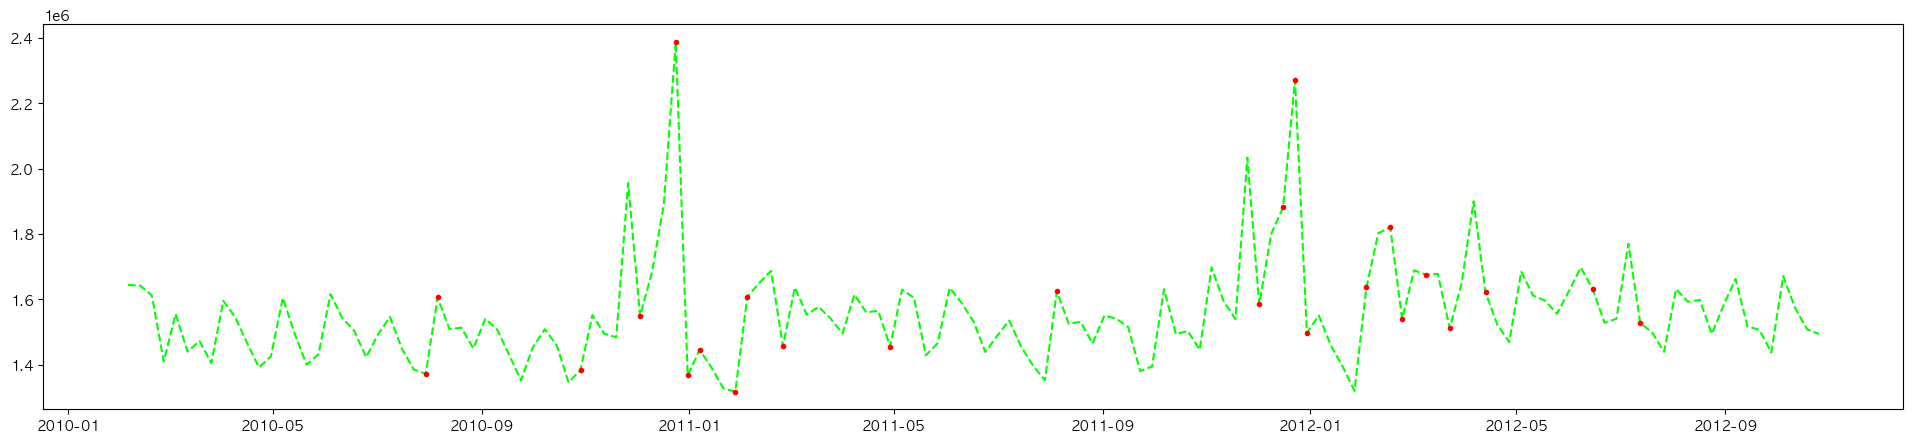

In [17]:
# ▶ predict data
plt.figure(figsize=(24,5))
plt.plot(df1['Date'], df1['Weekly_Sales'], linestyle='--', color='lime');
plt.plot(df1.loc[df1['anomaly']==1,'Date'], df1.loc[df1['anomaly']==1,'Weekly_Sales'], 'o', color='red', markersize=3);